In [1]:
from os import listdir
from os.path import isfile, join
import sys
import copy
import re
import numpy as np

from scipy.signal import stft
import scipy.io as sio
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd
import csv

from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from tqdm import tqdm
from utils import Person, simple_low_pass, exp_feat, window_spikes, analyze, do_tc_full, train_svm_single
import pickle as pkl
import peakutils
import pywt

from jAER_utils.converter import aedat2numpy
from utils import analyze

import pandas as pd
import seaborn as sns
import cv2
from sklearn.feature_extraction.image import extract_patches_2d

In [2]:
# general stuff
fs = 200  # sampling frequency of MYO
VERBOSE = True
data_dir = '/Users/enea/Dropbox/Capocaccia2019_Gesture_DVS_Myo/Dataset/'
classes = classes = ['pinky', 'elle', 'yo', 'index', 'thumb']
classes_dict = {'pinky': 0, 'elle': 1, 'yo': 2, 'index': 3, 'thumb': 4}
classes_inv = {v: k for k, v in classes_dict.items()}

Load all data into subject obects 

In [3]:
subjects = {}
names = [name for name in listdir(data_dir) if "emg" in name]
for name in names:
    _emg = np.load(data_dir + '{}'.format(name)).astype('float32')
    _ann = np.concatenate([np.array(['none']), np.load(data_dir + '{}'.format(name.replace("emg","ann")))[:-1]])
    
    subjects["_".join(name.split("_")[:2])] = Person(name.split("_")[0], _emg, _ann, classes=classes)
    
    if VERBOSE:
        print("Loaded {}: EMG = [{}] // ANN = [{}]".format("_".join(name.split("_")[:2]), _emg.shape, len(_ann)))
print("Data Loaded! {} Sessions".format(len(subjects.keys())))

# separates data in correct trial type
for name, data in subjects.items():
    for _class in classes:
        _annotation = np.float32(data.ann == _class)
        derivative = np.diff(_annotation)/1.0
        begins = np.where(derivative == 1)[0]
        ends = np.where(derivative == -1)[0]
        for b, e in zip(begins, ends):
            _trials = data.emg[b:e]
            data.trials[_class].append(_trials)
            data.begs[_class].append(b)
            data.ends[_class].append(e)
print("Done sorting trials!")

Loaded subject10_session03: EMG = [(25324, 8)] // ANN = [25324]
Loaded subject08_session02: EMG = [(25318, 8)] // ANN = [25318]
Loaded subject09_session03: EMG = [(25169, 8)] // ANN = [25169]
Loaded subject09_session02: EMG = [(23455, 8)] // ANN = [23455]
Loaded subject10_session02: EMG = [(25318, 8)] // ANN = [25318]
Loaded subject08_session03: EMG = [(25328, 8)] // ANN = [25328]
Loaded subject08_session01: EMG = [(25294, 8)] // ANN = [25294]
Loaded subject10_session01: EMG = [(25339, 8)] // ANN = [25339]
Loaded subject09_session01: EMG = [(25140, 8)] // ANN = [25140]
Loaded subject03_session03: EMG = [(25328, 8)] // ANN = [25328]
Loaded subject07_session02: EMG = [(25304, 8)] // ANN = [25304]
Loaded subject02_session02: EMG = [(25331, 8)] // ANN = [25331]
Loaded subject06_session03: EMG = [(24903, 8)] // ANN = [24903]
Loaded subject05_session01: EMG = [(25358, 8)] // ANN = [25358]
Loaded subject06_session02: EMG = [(24850, 8)] // ANN = [24850]
Loaded subject02_session03: EMG = [(2531

Now every subject has different fields, each field is a dictionary and the keys are the gestures.
We have the following fields: begs (beginning time of trials), ends (end time of trials), trials (actual myo data)

In [4]:
# this is to find the zero timestepping of the davis
def find_trigger(ts):
    return np.where(np.diff(ts) < 0)[0][0]

def create_frame(x, y, dim=(128, 128)):
    img = np.zeros(dim)
    for _x, _y in zip(x.astype('int32'), y.astype('int32')):
        img[dim[0] - 1 - _x,_y] += 1
#     return np.log10(img / np.max(img) + 1e-10)
    return img 

In [51]:
subject = 'subject02_session03'
# decoders takes some time since it is a very long recordings, especially with DAVIS
events = aedat2numpy(data_dir + subject +'_dvs.aedat')
events = events[:, find_trigger(events[2]):]
events[2] = events[2] / 1e3
print(events.shape)

(4, 4195686)


(4, 4061)


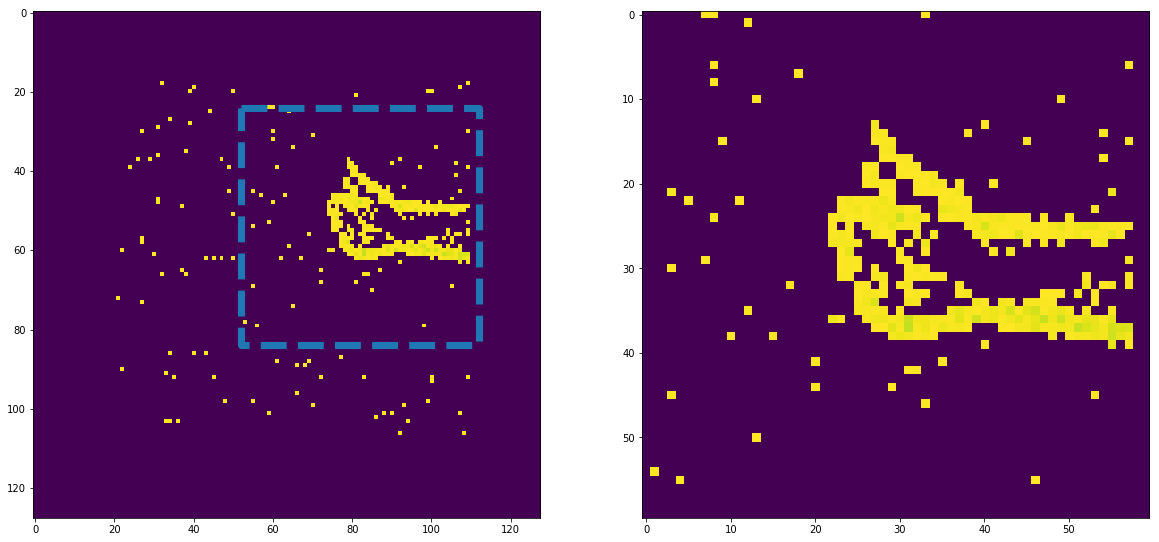

In [66]:
gesture = 'thumb'
trial = 1
# load beginning and end 
b = np.array(subjects[subject].begs[gesture][trial]) / fs
e = np.array(subjects[subject].ends[gesture][trial]) / fs

frame_size = 0.2
shift = 1.
beginning = b + shift
ending = beginning + frame_size
# slice
sl = (events[2] > beginning) & (events[2] < ending)

img = events[:, sl]
print(img.shape)
fig, ax = plt.subplots(1, 2, figsize=(20,10))

beg_int = int(shift * fs)
end_int = int((shift + frame_size) * fs)


sll = (img[1] > 20) & (img[1] < 110) & (img[0] > 20) & (img[0] < 110)

kkk = create_frame(img[1][sll], img[0][sll])

frame = np.uint8(kkk * 255)
# blurred = cv2.GaussianBlur(frame, (5, 5), 0)
# thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

M = cv2.moments(frame)
x = int(M["m10"] / M["m00"])
y = int(M["m01"] / M["m00"])

_ = ax[0].imshow(frame)
ax[0].plot([x - 30, x + 30, x + 30, x - 30, x - 30], 
           [y  - 30, y  - 30, y + 30, y  + 30, y  - 30], '--', linewidth=7)

_ = ax[1].imshow(frame[y - 30: y + 30, x-30:x+30])



In [67]:
print(frame[50])

[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0 254 252 255   0   0 250 255 254   0   0 251   0 254   0   0   0
   0 253 251 250 255 255 244 255 255 254 254 252 255 250 255 255 254 247
 255   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]


In [ ]:
a = (img[0] > (x - 30)) & (img[0] < (x + 30))
b = (img[1] > (127 - y - 30)) & (img[1] < (127 - y + 30))
xx = img[0][a & b]
yy = img[1][a & b]
ts = img[2][a & b]
pol = img[3][a & b]

plt.plot(xx, yy, '.')

In [5]:
for subject, data in sorted(subjects.items()):

    # decoders takes some time since it is a very long recordings, especially with DAVIS
    events = aedat2numpy(data_dir + subject +'_dvs.aedat')
    events = events[:, find_trigger(events[2]):]
    events[2] = events[2] / 1e3
    
    for gesture in classes:
        for trial in range(5):
            print("{} :: {} :: {}".format(subject, gesture, trial))
            # load beginning and end 
            b = np.array(data.begs[gesture][trial]) / fs
            e = np.array(data.ends[gesture][trial]) / fs

            frame_size = 2
            shift = 0.
            beginning = b + shift
            ending = beginning + frame_size

            # slice
            sl = (events[2] > beginning) & (events[2] < ending)

            img = events[:, sl]

            beg_int = int(shift * fs)
            end_int = int((shift + frame_size) * fs)

            sll = (img[1] > 20) & (img[1] < 110) & (img[0] > 20) & (img[0] < 110)

#             frame = np.uint8(create_frame(img[1][sll], img[0][sll]) * 254)
#             blurred = cv2.GaussianBlur(frame, (5, 5), 0)
#             thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

            kkk = create_frame(img[1][sll], img[0][sll])
            frame = np.uint8(kkk * 255)

            M = cv2.moments(frame)
            x = int(M["m10"] / M["m00"])
            y = int(M["m01"] / M["m00"])

            a = (img[0] > (x - 30)) & (img[0] < (x + 30))
            b = (img[1] > (127 - y - 30)) & (img[1] < (127 - y + 30))
            xx = img[0][a & b]
            yy = img[1][a & b]
            ts = img[2][a & b]
            pol = img[3][a & b]

            data.x[gesture].append(xx - min(xx))
            data.y[gesture].append(yy - min(yy))
            data.ts[gesture].append(ts - min(ts))
            data.pol[gesture].append(pol)


subject10_session03 :: pinky :: 0
subject10_session03 :: pinky :: 1
subject10_session03 :: pinky :: 2
subject10_session03 :: pinky :: 3
subject10_session03 :: pinky :: 4
subject10_session03 :: elle :: 0
subject10_session03 :: elle :: 1
subject10_session03 :: elle :: 2
subject10_session03 :: elle :: 3
subject10_session03 :: elle :: 4
subject10_session03 :: yo :: 0
subject10_session03 :: yo :: 1
subject10_session03 :: yo :: 2
subject10_session03 :: yo :: 3
subject10_session03 :: yo :: 4
subject10_session03 :: index :: 0
subject10_session03 :: index :: 1
subject10_session03 :: index :: 2
subject10_session03 :: index :: 3
subject10_session03 :: index :: 4
subject10_session03 :: thumb :: 0
subject10_session03 :: thumb :: 1
subject10_session03 :: thumb :: 2
subject10_session03 :: thumb :: 3
subject10_session03 :: thumb :: 4
subject08_session02 :: pinky :: 0
subject08_session02 :: pinky :: 1
subject08_session02 :: pinky :: 2
subject08_session02 :: pinky :: 3
subject08_session02 :: pinky :: 4


subject03_session03 :: thumb :: 2
subject03_session03 :: thumb :: 3
subject03_session03 :: thumb :: 4
subject07_session02 :: pinky :: 0
subject07_session02 :: pinky :: 1
subject07_session02 :: pinky :: 2
subject07_session02 :: pinky :: 3
subject07_session02 :: pinky :: 4
subject07_session02 :: elle :: 0
subject07_session02 :: elle :: 1
subject07_session02 :: elle :: 2
subject07_session02 :: elle :: 3
subject07_session02 :: elle :: 4
subject07_session02 :: yo :: 0
subject07_session02 :: yo :: 1
subject07_session02 :: yo :: 2
subject07_session02 :: yo :: 3
subject07_session02 :: yo :: 4
subject07_session02 :: index :: 0
subject07_session02 :: index :: 1
subject07_session02 :: index :: 2
subject07_session02 :: index :: 3
subject07_session02 :: index :: 4
subject07_session02 :: thumb :: 0
subject07_session02 :: thumb :: 1
subject07_session02 :: thumb :: 2
subject07_session02 :: thumb :: 3
subject07_session02 :: thumb :: 4
subject02_session02 :: pinky :: 0
subject02_session02 :: pinky :: 1


subject04_session01 :: index :: 4
subject04_session01 :: thumb :: 0
subject04_session01 :: thumb :: 1
subject04_session01 :: thumb :: 2
subject04_session01 :: thumb :: 3
subject04_session01 :: thumb :: 4
subject05_session02 :: pinky :: 0
subject05_session02 :: pinky :: 1
subject05_session02 :: pinky :: 2
subject05_session02 :: pinky :: 3
subject05_session02 :: pinky :: 4
subject05_session02 :: elle :: 0
subject05_session02 :: elle :: 1
subject05_session02 :: elle :: 2
subject05_session02 :: elle :: 3
subject05_session02 :: elle :: 4
subject05_session02 :: yo :: 0
subject05_session02 :: yo :: 1
subject05_session02 :: yo :: 2
subject05_session02 :: yo :: 3
subject05_session02 :: yo :: 4
subject05_session02 :: index :: 0
subject05_session02 :: index :: 1
subject05_session02 :: index :: 2
subject05_session02 :: index :: 3
subject05_session02 :: index :: 4
subject05_session02 :: thumb :: 0
subject05_session02 :: thumb :: 1
subject05_session02 :: thumb :: 2
subject05_session02 :: thumb :: 3


subject06_session01 :: index :: 1
subject06_session01 :: index :: 2
subject06_session01 :: index :: 3
subject06_session01 :: index :: 4
subject06_session01 :: thumb :: 0
subject06_session01 :: thumb :: 1
subject06_session01 :: thumb :: 2
subject06_session01 :: thumb :: 3
subject06_session01 :: thumb :: 4


In [69]:
pkl.dump(subjects, open('10_people_dvs_emg_v2.pkl', 'wb'))

In [70]:
data = pkl.load(open('10_people_dvs_emg_v2.pkl', 'rb'))

In [ ]:
sub = 'Melika2'
trial = 1
gesture = 'index'
_x = data[sub].y[gesture][trial]
_y = data[sub].x[gesture][trial]
_ts = data[sub].ts[gesture][trial]
_p = data[sub].pol[gesture][trial]

fil = (_ts > 0.25) & (_ts < 1)
frame = create_frame(_x[fil], _y[fil], dim=(60, 60))
plt.imshow(frame)
plt.figure()
_ = plt.plot(data[sub].trials[gesture][trial])


frame = np.uint8(frame * 254)
blurred = cv2.GaussianBlur(frame, (5, 5), 0)
thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

sift = cv2.xfeatures2d.SIFT_create()
(kps, descs) = sift.detectAndCompute(thresh, None)

print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))

surf = cv2.xfeatures2d.SURF_create()
(kps, descs) = surf.detectAndCompute(thresh, None)
print("# kps: {}, descriptors: {}".format(len(kps), descs.shape))

In [ ]:
# extract sift and surf 
for subject, sub in data.items():
    for gesture in classes:
        for trial in range(5):

            _x = sub.y[gesture][trial]
            _y = sub.x[gesture][trial]
            _ts = sub.ts[gesture][trial]
            _p = sub.pol[gesture][trial]

            fil = (_ts > 0.200) & (_ts < 2)
            frame = create_frame(_x[fil], _y[fil], dim=(60, 60))

            frame = np.uint8(frame * 254)
            blurred = cv2.GaussianBlur(frame, (5, 5), 0)
            thresh = cv2.threshold(blurred, 60, 255, cv2.THRESH_BINARY)[1]

            sift = cv2.xfeatures2d.SIFT_create()
            (kps, descs1) = sift.detectAndCompute(thresh, None)
            sub.sift[gesture].append(descs1)

            surf = cv2.xfeatures2d.SURF_create()
            (kps, descs2) = surf.detectAndCompute(thresh, None)
            sub.surf[gesture].append(descs2)
            
            print("{}::{}::{}::{}::{}".format(subject, gesture, trial, descs1.shape, descs2.shape))

In [ ]:
X1 = []
X2 = []
Y = []

for subject, sub in data.items():
    for gesture in classes:
        for trial in range(5):
            if sub.sift[gesture][trial].shape[0] >= 7 and sub.surf[gesture][trial].shape[0] >= 7: 
                X1.append(sub.sift[gesture][trial][:7])
                X2.append(sub.surf[gesture][trial][:7])
                Y.append(classes_dict[gesture])
            

X1 = np.array(X1)
X2 = np.array(X2)
X = np.hstack([X1.reshape(X1.shape[0], -1), X2.reshape(X1.shape[0], -1)])
Y = np.array(Y)

X -= np.mean(X, 0, keepdims=True)
X /= np.std(X, 0, keepdims=True) + 1e-15

print(np.array(X1).shape)
print(np.array(X2).shape)
print(np.array(Y).shape)


In [ ]:
print(do_tc_full(X, Y.reshape(-1,1 ), pca_comp=4, avg=True))

In [7]:
# extract sift and surf 

X1 = []
X2 = []
Y = []

for subject, sub in subjects.items():
    if subject not in ['Enea3', 'Melika2']:
        for gesture in classes:
            for trial in range(5):

                _emg = sub.trials[gesture][trial]

                if _emg.shape[0] < 400:
                    _emg = np.vstack([_emg, np.zeros((400 - _emg.shape[0], 8))])
                _emg = _emg[80:400]
                X2.append(_emg.reshape(-1, 20, 8))

                _x = sub.y[gesture][trial]
                _y = sub.x[gesture][trial]
                _ts = sub.ts[gesture][trial]
                _p = sub.pol[gesture][trial]
                for i in np.arange(0.4, 2.0, 0.1):
                    fil = (_ts > i) & (_ts < i + .1)
                    kkk = create_frame(_x[fil], _y[fil], dim=(60, 60))
                    frame = np.uint8(kkk * 255)
                    X1.append(frame)
                    Y.append(classes_dict[gesture])
#                     print("{}::{}::{}::{}::{}".format(subject, gesture, trial, frame.shape, i))

In [73]:
X1 = np.array(X1)
X2 = np.array(X2).reshape(-1, 40, 8)
Y = np.array(Y).reshape(-1, 1)

print(np.array(X1).shape)
print(np.array(X2).shape)
print(np.array(Y).shape)

# np.save('_cc19_hand_gestures_10p_img', X1)
# np.save('_cc19_hand_gestures_10p_emg', X2)
# np.save('_cc19_hand_gestures_10p_lbl', Y)

(6000, 60, 60)
(6000, 40, 8)
(6000, 1)


In [ ]:
print((X1[0] - np.min(X1[0]))

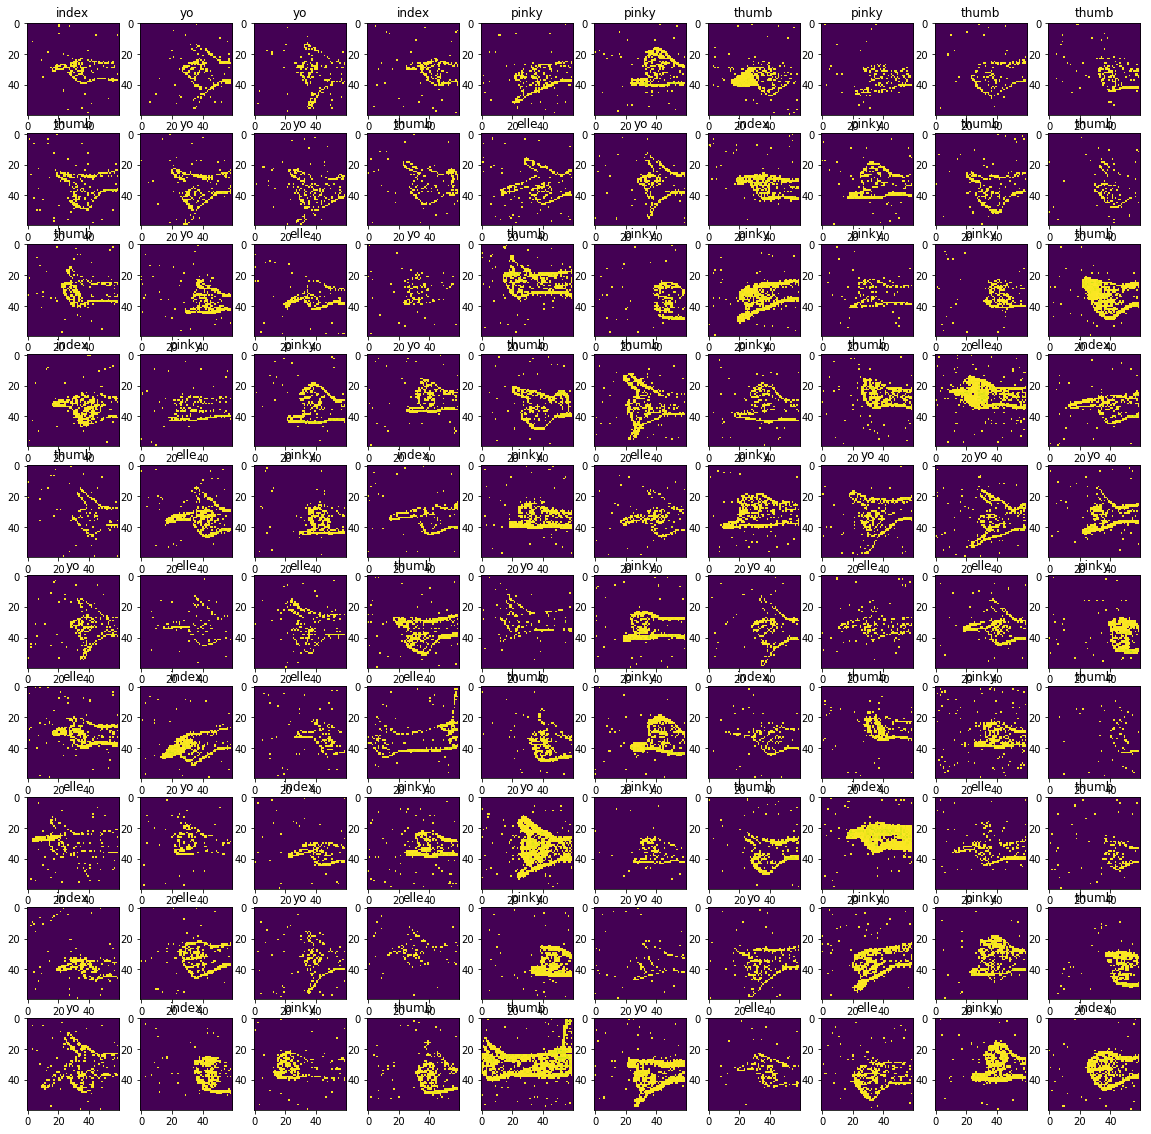

In [9]:
fig, ax = plt.subplots(10, 10, figsize=(20, 20))

for i in range(10):
    for j in range(10):
        _idx = np.random.randint(5600)
        
        ax[i][j].imshow(X1[_idx])
        ax[i][j].set_title(classes_inv[Y[_idx]])

# plt.savefig('example_dataset.pdf')

In [ ]:
def extract_grid(img, size=(20, 20), shift=None):
    if shift == None:
        shift = size
    x, y = img.shape
    patches = []
    n_win_x = (x - size[0]) // shift[0] + 1
    n_win_y = (y - size[1]) // shift[1] + 1
    for i in range(n_win_x):
        for j in range(n_win_y):
            patches.append(img[i * shift[0]:i * shift[0] + size[0], j * shift[1]:j * shift[1] + size[1]])
            
    return patches

pp = extract_grid(X1[100], (16, 16), shift=(8, 8))
print(len(pp))
fig, ax = plt.subplots(6, 6)
for i, ppp in enumerate(pp):
    ax[i//6][i % 6].imshow(ppp, aspect='auto')

In [ ]:
# SIFT features codebook
all_V_sift = []
all_patches = []
sift = cv2.xfeatures2d.SIFT_create()

for j, img in enumerate(X1):
    a = img
    a -= np.min(a)
    a /= np.max(a)
    frame = np.uint8(a * 255)
    
    patches = extract_patches_2d(frame, (20, 20), max_patches=0.1)

    print("{}::{}/{}".format(len(patches), j, len(X1)))
    _patches = []
    for p in patches:
        
        (kps, descs1) = sift.detectAndCompute(p, None)
        if descs1 is not None:
            _patches.append(descs1)
    all_V_sift.append(_patches)
    
for_kmeans = np.vstack([np.vstack(i) for i in all_V_sift])
print(for_kmeans.shape)

In [ ]:
np.array(all_V_sift[0][0]).shape

In [ ]:
for_kmeans = np.vstack([np.vstack(i) for i in all_V_sift])
print(for_kmeans.shape)

In [ ]:
np.save('kepoints_20x20_168_sift', for_kmeans)

In [ ]:
for_kmeans = np.load('kepoints_20x20_168_sift.npy')
print(for_kmeans.shape)

In [ ]:
# kmeans
from sklearn.cluster import KMeans
k = 500
kmeans = KMeans(n_clusters=k, random_state=0).fit(for_kmeans[::5])
C_sift = kmeans.cluster_centers_
print(C_sift.shape)

In [ ]:
np.save('centers_20x20_840_sift', C_sift)

In [ ]:
# create histogram features
all_h_sift = []

for feat in enumerate(all_V_sift):
    
    h = np.zeros((k,))
    
    for p in feat:
        _id = np.argmin(np.linalg.norm(p - C_sift, axis=1))
        h[_id] += 1
                
    all_h_sift.append(h)

    
all_h_sift = np.array(all_h_sift)
print(all_h_sift.shape)


In [ ]:
# create histogram features
all_h_sift = []
sift = cv2.xfeatures2d.SIFT_create()

for j, img in enumerate(X1):
    a = img
    a -= np.min(a)
    a /= np.max(a)
    frame = np.uint8(a * 255)

    patches = extract_grid(frame)
    h = np.zeros((k,))
    
    for p in patches:
        (kps, descs1) = sift.detectAndCompute(p, None)
        
        if descs1 is not None:
            for d in descs1:
                _id = np.argmin(np.linalg.norm(d - C_sift, axis=1))
                h[_id] += 1
                
    all_h_sift.append(h)

    
all_h_sift = np.array(all_h_sift)
print(all_h_sift.shape)


In [ ]:
print(all_h_sift[0])

In [ ]:
_XX = np.array([i / np.linalg.norm(i) for i in all_h_sift])

print(do_tc_full(_XX, Y, avg=True, verbose=True))

In [ ]:
im = X1[2113]
im -= np.min(im)
im /= np.max(im)
print(im.mean())
fig, ax = plt.subplots(2, 3)
ax[0][0].imshow(im)

im = np.float32(im)
 
# Calculate gradient 
gx = cv2.Sobel(im, cv2.CV_32F, 1, 0, ksize=1)
gy = cv2.Sobel(im, cv2.CV_32F, 0, 1, ksize=1)
print(gy.shape)
ax[0][1].imshow(np.abs(gx))
ax[0][2].imshow(np.abs(gy))

# mag angle
mag, angle = cv2.cartToPolar(gx, gy, angleInDegrees=True)
ax[1][0].imshow(np.abs(mag))
ax[1][1].imshow(angle)
plt.tight_layout()

patches = extract_grid(im, (8, 8))
kk = patches[17]
gx_p = cv2.Sobel(kk, cv2.CV_32F, 1, 0, ksize=1)
gy_p = cv2.Sobel(kk, cv2.CV_32F, 0, 1, ksize=1)

# mag angle
mag_p, angle_p = cv2.cartToPolar(gx_p, gy_p, angleInDegrees=True)
angle_p = np.abs(angle_p - 180)



In [ ]:
N_BUCKETS = 9
CELL_SIZE = 8  # Each cell is 8x8 pixels
BLOCK_SIZE = 2  # Each block is 2x2 cells

def assign_bucket_vals(m, d, bucket_vals):
    left_bin = int(d / 20.) % N_BUCKETS
    # Handle the case when the direction is between [160, 180)
    if (d == 180.):
        right_bin = 0
    else:
        right_bin = (int(d / 20.) + 1) % N_BUCKETS
    
    if left_bin < right_bin:
        left_val= m * (right_bin * 20 - d) / 20
        right_val = m * (d - left_bin * 20) / 20
    else:
        left_val= m * (d - left_bin * 20) / 20
        right_val = m * (right_bin * 20 - d) / 20 
    if left_val < 0:
        left_val = 0.
    if right_val < 0:
        right_val = 0.
    bucket_vals[left_bin] += np.abs(left_val)
    bucket_vals[right_bin] += np.abs(right_val)
    
all_veat = []
for j, im in enumerate(X1):
    im -= np.min(im)
    im /= np.max(im)
    im = np.float32(im)
    blocks = extract_grid(im, (16, 16), (8, 8))

    all_buckets = []
    for block in blocks:
        cells = extract_grid(block, (8, 8))
        to_concat = []
        for cell in cells:
            bucket_vals = np.zeros((N_BUCKETS))
            gx_p = cv2.Sobel(cell, cv2.CV_32F, 1, 0, ksize=1)
            gy_p = cv2.Sobel(cell, cv2.CV_32F, 0, 1, ksize=1)

            # mag angle
            mag_p, angle_p = cv2.cartToPolar(gx_p, gy_p, angleInDegrees=True)
            mag_p = np.abs(mag_p)
            angle_p = np.abs(angle_p - 180)
            for m, d in zip(mag_p.reshape(-1,), angle_p.reshape(-1)):
                assign_bucket_vals(m, d, bucket_vals)
            to_concat.append(bucket_vals)
        veat = np.array(to_concat)
        all_buckets.append(veat)

    veat = np.array(all_buckets)
    all_veat.append(veat)
    print(j)

print(np.array(all_veat).shape)

In [ ]:
eps = 1e-15
print(np.array(all_veat).shape)
all_veat_res = np.array(all_veat).reshape(5600, 36, -1)
# eps = 1e-7
all_veat_res /= np.sqrt(np.sum(all_veat_res ** 2, 2, keepdims=True) + eps + 1)
# all_veat_res = np.sqrt(all_veat_res)
# all_veat_res /= np.linalg.norm(all_veat_res, axis=2, keepdims=True) + eps
# all_veat_norm = all_veat_res / (np.linalg.norm(all_veat_res, axis=1, keepdims=True) + 1e-15)
# all_veat_norm = all_veat_res
all_veat_final = all_veat_res.reshape(5600, -1)
# all_veat_final = all_veat_final / (np.linalg.norm(all_veat_final, axis=1, keepdims=True) + 1e-15)

print(all_veat_final.shape)

In [ ]:
np.sum(all_veat_res ** 2, 2, keepdims=True).shape

In [ ]:
np.save('hog_16x16_8x8_sqrt_norm', all_veat_final)

In [ ]:
acc_tr, acc_te, _, _ = do_tc_full(all_veat_final, np.array(Y).reshape(-1,1), pca_comp=300, verbose=True, avg=True)

In [ ]:
# emg = np.load('_cc19_hand_gestures_10p_emg.npy')
# emg_mav = np.array([analyze(i, frame_len=0.2, frame_step=0.2, feat='MAV') for i in emg])
# emg_sd = np.array([analyze(i, frame_len=0.2, frame_step=0.2, feat='SD') for i in emg])
# emg_rms = np.array([analyze(i, frame_len=0.2, frame_step=0.2, feat='RMS') for i in emg])

print(np.hstack([emg_mav, emg_rms, emg_sd]).shape)
emg = np.hstack([emg_mav, emg_rms, emg_sd]).reshape(-1, 24)
np.save('emg_mav_rms_sd_02', emg)

In [2]:
dvs = np.load('hog_16x16_8x8_sqrt_norm.npy')
emg = np.load('emg_mav_rms_sd_02.npy')
lbl = np.load('_cc19_hand_gestures_10p_lbl.npy')
print(emg.shape)
print(dvs.shape)
print(lbl.shape)



(5600, 24)
(5600, 1296)
(5600, 1)


In [ ]:
emg -= np.mean(emg, 0, keepdims=True)
emg /= np.std(emg, 0, keepdims=True) + 1e-15
acc_tr, acc_te, _, _ = do_tc_full(emg, lbl, pca_comp=0, verbose=False, avg=True, kernel='rbf')
print("{:.4} :: {:.4}".format(acc_tr, acc_te))

In [ ]:
dvs -= np.mean(dvs, 0, keepdims=True)
dvs /= np.std(dvs, 0, keepdims=True) + 1e-15
acc_tr, acc_te, _, _ = do_tc_full(dvs, lbl, pca_comp=0, verbose=True, avg=True, kernel='rbf')
print("{:.4} :: {:.4}".format(acc_tr, acc_te))

In [3]:
dvs -= np.mean(dvs, 0, keepdims=True)
dvs /= np.std(dvs, 0, keepdims=True) + 1e-15
acc_tr, clf = train_svm_single(dvs, lbl, kernel='rbf')
# print("{:.4} :: {:.4}".format(acc_tr))

/Users/enea/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


IndexError: tuple index out of range

In [29]:
# Generate data and labels
trainData = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
trainLabels = np.array([0, 1, 0, 1], dtype=np.int32)
print(trainData.shape)
print(trainLabels.shape)
print(dvs.shape)
print(lbl.shape)
# Train the SVM:
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(2)
svm.setGamma(2)

svm.train(np.float32(dvs), cv2.ml.ROW_SAMPLE, np.int32(lbl))

# Store it by using OpenCV functions:
svm.save("model_debug_linear.xml")


(4, 2)
(4,)
(5600, 1296)
(5600, 1)


In [13]:
# Generate data and labels
trainData = np.array([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=np.float32)
trainLabels = np.array([0, 1, 0, 1], dtype=np.int32)
print(trainData.shape)
print(trainLabels.shape)
print(dvs.shape)
print(lbl.shape)
# Train the SVM:
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_RBF)
svm.setC(2)
svm.setGamma(2)

svm.train(np.float32(dvs), cv2.ml.ROW_SAMPLE, np.int32(lbl).squeeze())
output = svm.predict(np.float32(dvs))
print(output.shape)
# Store it by using OpenCV functions:
svm.save("model.xml")

# Now create a new SVM & load the model:
svm.load("model.xml")

(4, 2)
(4,)
(5600, 1296)
(5600, 1)


AttributeError: 'tuple' object has no attribute 'shape'

In [27]:
a = svm.getSupportVectors()
print(len(a))

5000


In [30]:
output = svm.predict(np.float32(dvs))
print(output[1].shape)
print(lbl.shape)
acc = np.sum((output[1].squeeze() - lbl.squeeze()) == 0) / len(output[1])
print(acc)

(5600, 1)
(5600, 1)
0.8139285714285714


In [26]:
# Store it by using OpenCV functions:
svm.save("model_svm_dvs.xml")


In [ ]:
acc_tr, acc_te, _, _ = do_tc_full(np.hstack([emg, dvs]), lbl, pca_comp=0, verbose=True, avg=True, kernel='rbf')
print("{:.4} :: {:.4}".format(acc_tr, acc_te))

In [ ]:
# Random location [200, 200] as an example.
loc_x = loc_y = 200

ydata = get_magnitude_hist_block(loc_x, loc_y)
ydata = ydata / np.linalg.norm(ydata)

xdata = range(len(ydata))
bucket_names = np.tile(np.arange(N_BUCKETS), BLOCK_SIZE * BLOCK_SIZE)

assert len(ydata) == N_BUCKETS * (BLOCK_SIZE * BLOCK_SIZE)
assert len(bucket_names) == len(ydata)

plt.figure(figsize=(10, 3))
plt.bar(xdata, ydata, align='center', alpha=0.8, width=0.9)
plt.xticks(xdata, bucket_names * 20, rotation=90)
plt.xlabel('Direction buckets')
plt.ylabel('Magnitude')
plt.grid(ls='--', color='k', alpha=0.1)
plt.title("HOG of block at [%d, %d]" % (loc_x, loc_y))
plt.tight_layout()

In [ ]:
all_hog = []

for img in X1:
    # HOG
    a = img
    a -= np.min(a)
    a /= np.max(a)
    frame = np.uint8(a * 255)

    patches = extract_grid(frame, (8, 8))

    all_hist = []

    for p in patches:
        gx = cv2.Sobel(p, cv2.CV_32F, 1, 0)
        gy = cv2.Sobel(p, cv2.CV_32F, 0, 1)


        mag, ang = cv2.cartToPolar(gx, gy)
        bin_n = 16
        bin = np.int32(bin_n*ang/(2*np.pi))
        bin_cells = bin[:100,:100], bin[100:,:100], bin[:100,100:], bin[100:,100:]
        mag_cells = mag[:100,:100], mag[100:,:100], mag[:100,100:], mag[100:,100:]
        hists = [np.bincount(b.ravel(), m.ravel(), bin_n) for b, m in zip(bin_cells, mag_cells)]
        hist = np.hstack(hists)
        all_hist.append(hist)
    # transform to Hellinger kernel
    hist = sum(all_hist)
    eps = 1e-7
    hist /= hist.sum() + eps
    hist = np.sqrt(hist)
    hist /= np.linalg.norm(hist) + eps

    all_hog.append(hist)
print(np.array(all_hog).shape)

In [ ]:
acc_tr, acc_te = do_tc_full(np.array(all_hog), np.array(Y).reshape(-1,1), verbose=True, avg=True)

In [ ]:
all_X, all_Y = [], []
n_ch = 8
preprocess = True
frame_len = 0.3
overlap = 0.0
frame_step = frame_len * (1. - overlap)
features = ['MAV', 'RMS', 'SD']
n_comp = 8
for i, idx in enumerate(X2):
    _sub = np.mean(np.abs(idx), 0)
    all_X.append(_sub)
    all_Y.append(Y[i])

all_X = np.vstack(all_X)
all_Y = np.vstack(all_Y)

all_X -= np.mean(all_X, 0, keepdims=True)
all_X /= np.std(all_X, 0, keepdims=True) + 1e-15

acc_tr, acc_te = do_tc_full(all_X, all_Y, verbose=True, pca_comp=n_comp, avg=False)
print("Train: {:.4} +/- {:.4}".format(np.mean(acc_tr), np.std(acc_tr)))
print("Test: {:.4} +/- {:.4}".format(np.mean(acc_te), np.std(acc_te)))

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()
(kps, descs) = sift.detectAndCompute(frame, None)

print(descs.shape)

In [ ]:
import csv
with open('gesture.csv', 'w') as f:
    csv_writer = csv.writer(f, delimiter=',')
    csv_writer.writerow(['x', 'y', 'type'])
    for i in range(img.shape[1]):
        csv_writer.writerow([img[0, i], img[1, i], img[3, i]])


In [ ]:
data = pd.read_csv('gesture.csv')

g = sns.jointplot("x", "y", data=data, size=20)
plt.savefig('spatial_density_yo.pdf')

In [ ]:
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
gm = GaussianMixture(4) 
gm.fit(img[0].reshape(-1, 1) / 180)

x = np.linspace(0, 1, 1000)
plt.hist(img[0] / 180, 50, density=True)
plt.plot(x.reshape(-1, 1), stats.norm.pdf(x, gm.means_[0], gm.covariances_[0]).T)
plt.plot(x.reshape(-1, 1), stats.norm.pdf(x, gm.means_[1], gm.covariances_[1]).T)
plt.plot(x.reshape(-1, 1), stats.norm.pdf(x, gm.means_[2], gm.covariances_[2]).T)



# All done with opencv

In [77]:
X1 = np.array(X1)
X2 = np.array(X2).reshape(-1, 40, 8)
Y = np.array(Y).reshape(-1, 1)

print(np.array(X1).shape)
print(np.array(X2).shape)
print(np.array(Y).shape)

(6000, 60, 60)
(6000, 40, 8)
(6000, 1)


In [221]:
hog = cv2.HOGDescriptor((16, 16), (16, 16), (8, 8), (8, 8), 9); 

X1_hog = []
frames = []
for img in X1:

    X1_hog.append(hog.compute(img).T)
    frames.append(img)

X1_hog = np.vstack(X1_hog)
frames = np.array(frames)
print(X1_hog.shape)
print(frames.shape)

(6000, 1296)
(6000, 60, 60)


In [87]:
# Generate data and labels
eps = 1e-15
dvs = X1_hog
lbl = np.squeeze(Y)

idx = np.random.permutation(len(dvs))
n_train = int(len(dvs))
idx_train = idx[:n_train]
idx_test = idx[n_train:]

dvs_train = dvs[idx_train]
dvs_test = dvs[idx_test]
lbl_train = lbl[idx_train]
lbl_test = lbl[idx_test]


print(lbl_train.shape)
print(dvs_train.shape)
print(lbl_test.shape)
print(dvs_test.shape)

# Train the SVM:
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(0.1)
svm.setGamma(0)

svm.train(np.float32(dvs_train), cv2.ml.ROW_SAMPLE, np.int32(lbl_train))

# Store it by using OpenCV functions:
svm.save("fullcv_svm_v3.xml")


(6000,)
(6000, 1296)
(0,)
(0, 1296)


In [88]:
output = svm.predict(np.float32(dvs_train))
acc = np.sum((output[1].squeeze() - lbl_train.squeeze()) == 0) / len(output[1])
print(acc)

0.663


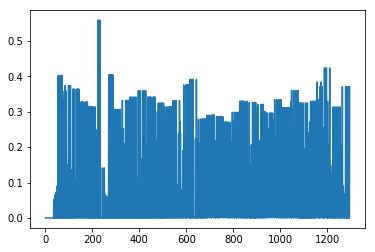

In [82]:
plt.plot(dvs_train[0])

In [217]:
print(X2.shape)
emg_mav = np.squeeze(np.array([analyze(i, frame_len=0.2, frame_step=0.2, feat='MAV') for i in X2]))
emg_rms = np.squeeze(np.array([analyze(i, frame_len=0.2, frame_step=0.2, feat='RMS') for i in X2]))
emg_sd = np.squeeze(np.array([analyze(i, frame_len=0.2, frame_step=0.2, feat='SD') for i in X2]))

emg = np.hstack([emg_mav, emg_rms, emg_sd])
print(emg.shape)

(6000, 40, 8)
(6000, 24)


In [222]:
# save
dvs = X1_hog
lbl = np.squeeze(Y)
join = np.hstack([emg, dvs])

pkl.dump({'hog': dvs, 'labels': lbl, 'emg': emg, 'frames': frames}, open('full_dataset_events.pkl', 'wb'))

In [218]:
# Generate data and labels
dvs = X1_hog
lbl = np.squeeze(Y)
join = np.hstack([emg, dvs])

idx = np.random.permutation(len(dvs))
n_train = int(len(dvs) * 0.8)
idx_train = idx[:n_train]
idx_test = idx[n_train:]


dvs_train = dvs[idx_train]
emg_train = emg[idx_train]
join_train = join[idx_train]
lbl_train = lbl[idx_train]

emg_mean = np.mean(emg_train, 0, keepdims=True)
dvs_mean = np.mean(dvs_train, 0, keepdims=True)
join_mean = np.mean(join_train, 0, keepdims=True)
emg_std = np.std(emg_train, 0, keepdims=True)
dvs_std = np.std(dvs_train, 0, keepdims=True)
join_std = np.std(join_train, 0, keepdims=True)

dvs_test = dvs[idx_test]
emg_test = emg[idx_test]
join_test = join[idx_test]
lbl_test = lbl[idx_test]

dvs_train = (dvs_train - dvs_mean) / dvs_std
emg_train = (emg_train - emg_mean) / emg_std
join_train = (join_train - join_mean) / join_std

dvs_test = (dvs_test - dvs_mean) / dvs_std
emg_test = (emg_test - emg_mean) / emg_std
join_test = (join_test - join_mean) / join_std

print(lbl_train.shape)
print(dvs_train.shape)
print(emg_train.shape)
print(lbl_test.shape)
print(dvs_test.shape)
print(emg_test.shape)

# # Train the SVM for dvs:
# svm_dvs = cv2.ml.SVM_create()
# svm_dvs.setType(cv2.ml.SVM_C_SVC)
# svm_dvs.setKernel(cv2.ml.SVM_RBF)
# svm_dvs.setC(0.1)
# svm_dvs.setGamma(1)
# svm_dvs.train(np.float32(dvs_train), cv2.ml.ROW_SAMPLE, np.int32(lbl_train))
# svm_dvs.save("fullcv_svm_dvs_v1.xml")

# output = svm_dvs.predict(np.float32(dvs_train))
# acc = np.sum((output[1].squeeze() - lbl_train.squeeze()) == 0) / len(output[1])
# print("DVS ONLY (Train) {}".format(acc))

# output = svm_dvs.predict(np.float32(dvs_test))
# acc = np.sum((output[1].squeeze() - lbl_test.squeeze()) == 0) / len(output[1])
# print("DVS ONLY (Test) {}".format(acc))

# # # Train the SVM for emg:
# svm_emg = cv2.ml.SVM_create()
# svm_emg.setType(cv2.ml.SVM_C_SVC)
# svm_emg.setKernel(cv2.ml.SVM_RBF)
# svm_emg.setC(0.1)
# svm_emg.setGamma(1)
# svm_emg.train(np.float32(emg_train), cv2.ml.ROW_SAMPLE, np.int32(lbl_train))
# svm_emg.save("fullcv_svm_emg_v1.xml")

# output = svm_emg.predict(np.float32(emg_train))
# acc = np.sum((output[1].squeeze() - lbl_train.squeeze()) == 0) / len(output[1])
# print("EMG ONLY (Train) {}".format(acc))

# output = svm_emg.predict(np.float32(emg_test))
# acc = np.sum((output[1].squeeze() - lbl_test.squeeze()) == 0) / len(output[1])
# print("EMG ONLY (Test) {}".format(acc))


# # Train the SVM for emg+dvs:

# svm_join = cv2.ml.SVM_create()
# svm_join.setType(cv2.ml.SVM_C_SVC)
# svm_join.setKernel(cv2.ml.SVM_RBF)
# svm_join.setC(0.1)
# svm_join.setGamma(1)
# svm_join.train(np.float32(join_train), cv2.ml.ROW_SAMPLE, np.int32(lbl_train))
# svm_join.save("fullcv_svm_join_v1.xml")

# output = svm_join.predict(np.float32(join_train))
# acc = np.sum((output[1].squeeze() - lbl_train.squeeze()) == 0) / len(output[1])
# print("JOIN (train) {}".format(acc))

# output = svm_join.predict(np.float32(join_test))
# acc = np.sum((output[1].squeeze() - lbl_test.squeeze()) == 0) / len(output[1])
# print("JOIN (test) {}".format(acc))



(4800,)
(4800, 1296)
(4800, 24)
(1200,)
(1200, 1296)
(1200, 24)


In [195]:
# Train the SVM for demg:
svm_emg = cv2.ml.SVM_create()
svm_emg.setType(cv2.ml.SVM_C_SVC)
svm_emg.setKernel(cv2.ml.SVM_LINEAR)
svm_emg.setC(0.01)
svm_emg.setGamma(2)
svm_emg.train(np.float32(emg_train), cv2.ml.ROW_SAMPLE, np.int32(lbl_train))
svm_emg.save("linear_svm_emg_v1.xml")

output = svm_emg.predict(np.float32(emg_train))
acc = np.sum((output[1].squeeze() - lbl_train.squeeze()) == 0) / len(output[1])
print("EMG ONLY (train) {}".format(acc))

output = svm_emg.predict(np.float32(emg_test))
acc = np.sum((output[1].squeeze() - lbl_test.squeeze()) == 0) / len(output[1])
print("EMG ONLY (test) {}".format(acc))


EMG ONLY (train) 0.5702083333333333
EMG ONLY (test) 0.5208333333333334


In [196]:
svm_dvs = cv2.ml.SVM_create()
svm_dvs.setType(cv2.ml.SVM_C_SVC)
svm_dvs.setKernel(cv2.ml.SVM_LINEAR)
svm_dvs.setC(0.01)
svm_dvs.setGamma(2)
svm_dvs.train(np.float32(dvs_train), cv2.ml.ROW_SAMPLE, np.int32(lbl_train))
svm_dvs.save("linear_svm_dvs_v1.xml")

output = svm_dvs.predict(np.float32(dvs_train))
acc = np.sum((output[1].squeeze() - lbl_train.squeeze()) == 0) / len(output[1])
print("DVS ONLY (Train) {}".format(acc))

output = svm_dvs.predict(np.float32(dvs_test))
acc = np.sum((output[1].squeeze() - lbl_test.squeeze()) == 0) / len(output[1])
print("DVS ONLY (Test) {}".format(acc))

DVS ONLY (Train) 0.9354166666666667
DVS ONLY (Test) 0.7225


In [197]:
# # Train the SVM for emg+dvs:
svm_join = cv2.ml.SVM_create()
svm_join.setType(cv2.ml.SVM_C_SVC)
svm_join.setKernel(cv2.ml.SVM_LINEAR)
svm_join.setC(0.01)
svm_join.setGamma(2)
svm_join.train(np.float32(join_train), cv2.ml.ROW_SAMPLE, np.int32(lbl_train))
svm_join.save("linear_svm_jon_v1.xml")

output = svm_join.predict(np.float32(join_train))
acc = np.sum((output[1].squeeze() - lbl_train.squeeze()) == 0) / len(output[1])
print("JOIN (train) {}".format(acc))

output = svm_join.predict(np.float32(join_test))
acc = np.sum((output[1].squeeze() - lbl_test.squeeze()) == 0) / len(output[1])
print("JOIN (test) {}".format(acc))

JOIN (train) 0.9908333333333333
JOIN (test) 0.8141666666666667


In [216]:
from numpy import array
a = array(np.squeeze(dvs_mean),'float32')
output_file = open('mean_dvs', 'wb')
a.tofile(output_file)
output_file.close()

a = array(np.squeeze(dvs_std),'float32')
output_file = open('std_dvs', 'wb')
a.tofile(output_file)
output_file.close()

a = array(np.squeeze(emg_mean),'float32')
output_file = open('mean_emg', 'wb')
a.tofile(output_file)
output_file.close()

a = array(np.squeeze(emg_std),'float32')
output_file = open('std_emg', 'wb')
a.tofile(output_file)
output_file.close()

a = array(np.squeeze(join_mean),'float32')
output_file = open('mean_jon', 'wb')
a.tofile(output_file)
output_file.close()

a = array(np.squeeze(join_std),'float32')
output_file = open('std_jon', 'wb')
a.tofile(output_file)
output_file.close()

In [214]:
for i in np.float32(np.squeeze(dvs_mean)):
    print(i)

0.21561025
0.0039753667
0.009630639
1.0563873e-05
0.27006882
9.946201e-06
0.009791441
0.004022423
0.21560691
0.2345715
0.004458814
0.011785141
6.641225e-05
0.293465
6.2268125e-05
0.014664382
0.0068483837
0.23455617
0.2276444
0.0039409655
0.009746301
1.30090975e-05
0.27111125
1.3013789e-05
0.008179124
0.0032167728
0.22764842
0.25340816
0.006330826
0.0145763
0.00010136514
0.29682264
9.8464305e-05
0.016694117
0.00785085
0.25337526
0.2109037
0.0034562664
0.0081857955
1.924145e-05
0.2607424
2.6642649e-05
0.007613642
0.0029373625
0.21090816
0.23583908
0.0054301918
0.013656427
0.00011434607
0.28771347
0.00010270165
0.015959922
0.007598772
0.23584002
0.22820175
0.00372272
0.008932253
3.356624e-05
0.2706663
4.1052426e-05
0.007337288
0.0030864687
0.22820598
0.25282502
0.009321606
0.02032125
0.000156034
0.30067882
0.00013908783
0.020598713
0.00944814
0.25282487
0.21108674
0.0033975642
0.007964923
8.0495265e-05
0.26308492
9.145809e-05
0.0073686256
0.0029741141
0.21108466
0.2334743
0.0074718553
0.0

In [212]:
print(len(dvs_mean[0]))

1296


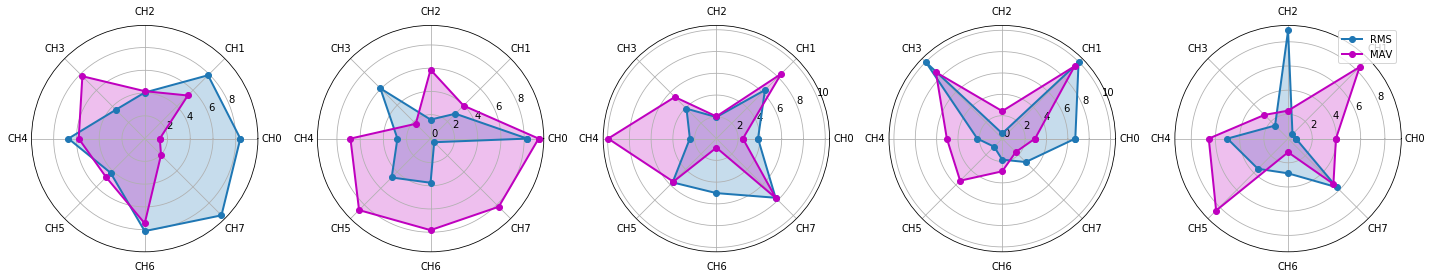

In [31]:
## test plot
import seaborn as sns

labels = np.array([f"CH{i}"for i in range(8)])

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
angles = np.append(angles, 0)

fig = plt.figure(figsize=(20, 10))
titles = ["PINKY", "ELLE", "THUMB", "INDEX", "YO"]

for j in range(5):
    ax = fig.add_subplot(151 + j, polar=True)
    stats = np.random.rand(8) * 10
    stats = np.append(stats, stats[0])

    ax.plot(angles, stats, 'o-', linewidth=2, label='RMS')
    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(angles * 180 / np.pi, labels)
    ax.grid(True)

    stats = np.random.rand(8) * 10
    stats = np.append(stats, stats[0])

    ax.plot(angles, stats, 'o-m', linewidth=2, label='MAV')
    ax.fill(angles, stats, 'm', alpha=0.25)
#     ax.set_title(titles[j])
    
ax.legend()

plt.tight_layout()

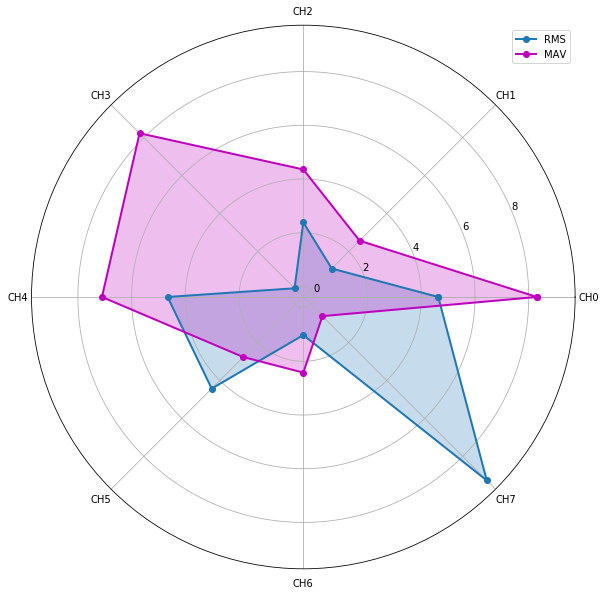

In [32]:
## test plot
import seaborn as sns

labels = np.array([f"CH{i}"for i in range(8)])

angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False)
angles = np.append(angles, 0)

fig = plt.figure(figsize=(20, 10))
titles = ["PINKY", "ELLE", "THUMB", "INDEX", "YO"]

ax = fig.add_subplot(111, polar=True)
stats = np.random.rand(8) * 10
stats = np.append(stats, stats[0])

ax.plot(angles, stats, 'o-', linewidth=2, label='RMS')
ax.fill(angles, stats, alpha=0.25)
ax.set_thetagrids(angles * 180 / np.pi, labels)
ax.grid(True)

stats = np.random.rand(8) * 10
stats = np.append(stats, stats[0])

ax.plot(angles, stats, 'o-m', linewidth=2, label='MAV')
ax.fill(angles, stats, 'm', alpha=0.25)
    
ax.legend()

